In [265]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from itertools import repeat
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_validate
from catboost import CatBoostClassifier, CatBoostRegressor, Pool, cv
#import lasio
from sklearn.metrics import mean_absolute_error as mae
from os import listdir
#from matplotlib_venn import venn2
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
%matplotlib inline

In [256]:
np.set_printoptions(precision=3, suppress=True)

In [2]:
def conv(s):
    if s == '':
        return np.nan
    return float(s.replace(',', '.'))

columns_to_conv = ['Нефть, т', 'Конденсат, т', 'Приемистость, м3/сут', 'Обводненность (вес), %', 'Нефть, м3', 'Жидкость, м3', \
                    'Дебит конденсата', 'Добыча растворенного газа, м3', 'Дебит попутного газа, м3/сут']
convertors = dict(zip(columns_to_conv, repeat(conv.__call__, len(columns_to_conv))))

def conv_date(x):
    if x.day != 1:
        return (x + pd.offsets.MonthBegin(1))
    else:
        return x

### Загружаем данные

In [3]:
df_train = pd.read_csv('init/1/train_1.8.csv', header = 0 ,encoding = 'cp1251', parse_dates = ['Дата'], converters= convertors)
df_test = pd.read_csv('init/1/test_1.9.csv', header = 0 ,encoding = 'cp1251', parse_dates = ['Дата'], converters= convertors)

df_coord_train = pd.read_csv('init/1/coords_train_1.1.csv', header = 0,encoding = 'cp1251')
df_coord_test = pd.read_csv('init/1/coords_test_1.1.csv', header = 0,encoding = 'cp1251')
df_coord_train = df_coord_train.rename(columns={'well_hash' : 'Скважина'})
df_coord_test = df_coord_test.rename(columns={'well_hash' : 'Скважина'})
df_coord_train_gr = df_coord_train.groupby('Скважина').mean().reset_index()
df_coord_test_gr = df_coord_test.groupby('Скважина').mean().reset_index()

df_frac_train = pd.read_csv('init/1/frac_train_1.csv', header = 0,encoding = 'cp1251')
df_frac_test = pd.read_csv('init/1/frac_test_1.csv', header = 0,encoding = 'cp1251')

df_gdis_train = pd.read_csv('init/1/gdis_train1.2.csv', header = 0,encoding = 'cp1251')
df_gdis_test = pd.read_csv('init/1/gdis_test1.2.csv', header = 0,encoding = 'cp1251')
df_gdis_train_gr = df_gdis_train.groupby('Скважина').mean().reset_index()
df_gdis_test_gr = df_gdis_test.groupby('Скважина').mean().reset_index()

### Центруем координаты (может и не надо)

In [5]:
df_coord_train['x'] = df_coord_train['ПЛАСТ_X'].astype(dtype='int32')
df_coord_train['y'] = df_coord_train['ПЛАСТ_Y'].astype(dtype='int32')
df_coord_train['x'] = df_coord_train['x'] - df_coord_train['x'].mean()
df_coord_train['y'] = df_coord_train['y'] - df_coord_train['y'].mean()

df_coord_train['x_head'] = df_coord_train['УСТЬЕ_X'].astype(dtype='int32')
df_coord_train['y_head'] = df_coord_train['УСТЬЕ_Y'].astype(dtype='int32')
df_coord_train['x_head'] = df_coord_train['x_head'] - df_coord_train['x_head'].mean()
df_coord_train['x_head'] = df_coord_train['x_head'] - df_coord_train['x_head'].mean()

In [ ]:
%matplotlib notebook
plt.figure(figsize=(10,10))
plt.scatter(df_coord_train.drop_duplicates('well_hash', 'first')['ПЛАСТ_X'], 
            df_coord_train.drop_duplicates('well_hash', 'first')['ПЛАСТ_Y'], color = 'g', label='train')
plt.scatter(df_coord_test.drop_duplicates('well_hash', 'first')['ПЛАСТ_X'], 
            df_coord_test.drop_duplicates('well_hash', 'first')['ПЛАСТ_Y'], color = 'r', label='test')
plt.legend()

In [6]:
w_coord_train = df_coord_train['Скважина'].unique()
w_coord_test = df_coord_test['Скважина'].unique()
w_train = df_train['Скважина'].unique()
w_test = df_test['Скважина'].unique()
w_frac_train = df_frac_train['Скважина'].unique()
w_frac_test = df_frac_test['Скважина'].unique()
w_gdis_train = df_gdis_train['Скважина'].unique()
w_gdis_test = df_gdis_test['Скважина'].unique()
#las_files_train = list(map(lambda x: x[:-4], listdir('init/1/las_train2/')))
#las_files_test = list(map(lambda x: x[:-4], listdir('init/1/las_test2/')))

In [8]:
print('# of wells in train: ', len(w_train))
print('# of wells in coord train: ', len(w_coord_train))
print('# of wells intersect train and coord train: ', len(list(set(w_train) & set(w_coord_train))))
print('# of wells in frac train: ', len(w_frac_train))
print('# of wells in gdis train: ', len(w_gdis_train))
#print('# of wells in las train: ', len(las_files_train))

# of wells in train:  563
# of wells in coord train:  234
# of wells intersect train and coord train:  233
# of wells in frac train:  490
# of wells in gdis train:  388


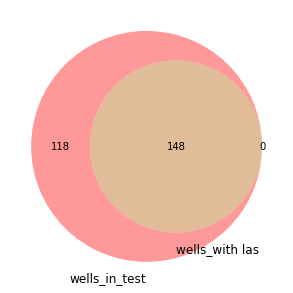

In [26]:
plt.figure(figsize=(5,5))
venn2(subsets = [set(w_test), set(las_files_test)],
      set_labels=['wells_in_test','wells_with las'] )
plt.show()

In [9]:
print('# of wells in test: ', len(w_test))
print('# of wells in coord test: ', len(w_coord_test))
print('# of wells in frac test: ', len(w_frac_test))
print('# of wells in gdis test: ', len(w_gdis_test))
#print('# of wells in las test: ', len(las_files_test))

# of wells in test:  266
# of wells in coord test:  137
# of wells in frac test:  193
# of wells in gdis test:  106


### Рассчитаем нужные свойства и объединим стобцы

In [10]:
df_train.loc[:, 'Дата'] = df_train['Дата'].apply(conv_date)

df_train['days_on'] = df_train['Время работы, ч']/24

df_train['oil_rate'] = df_train['Нефть, м3']/(df_train['Время работы, ч']/24)

df_train['oil_prod'] = df_train['Нефть, т']

df_train['liq_rate'] = df_train['Жидкость, м3']/(df_train['Время работы, ч']/24)

df_train.loc[df_train['liq_rate'].isnull(), 'liq_rate'] = df_train[df_train['liq_rate'].isnull()]['Дебит жидкости']

df_train.loc[df_train['oil_rate'].isnull(), 'oil_rate'] = df_train[df_train['oil_rate'].isnull()]['liq_rate'] \
                                                            *(1-df_train[df_train['oil_rate'].isnull()]['Обводненность']/100)

df_train['wct'] = 1 - df_train['Нефть, м3']/df_train['Жидкость, м3']
df_train.loc[df_train['wct'].isnull(), 'wct'] = df_train.loc[df_train['wct'].isnull(), 'Обводненность']/100

df_train['gas_rate'] = df_train['Попутный газ, м3']/(df_train['Время работы, ч']/24)
df_train.loc[df_train['gas_rate'].isnull(), 'gas_rate'] = df_train[df_train['gas_rate'].isnull()]['Газовый фактор']* \
                                                           df_train[df_train['gas_rate'].isnull()]['oil_rate'] 

df_train['gas_prod'] = df_train['Попутный газ, м3']

df_train['gf'] = df_train['Попутный газ, м3']/df_train['Нефть, т']
df_train.loc[df_train['gf'].isnull(), 'gf'] = df_train[df_train['gf'].isnull()]['Газовый фактор']

df_train['state'] = df_train['Состояние']
df_train.loc[df_train['state'].isnull(), 'state'] = df_train.loc[df_train['state'].isnull(), 'Состояние на конец месяца'] 

df_train['frac'] = df_train['Скважина'].apply(lambda x: x in df_frac_train['Скважина'].values).astype(int)

In [11]:
oil_dens_mean = df_train[df_train['Скважина'].isin(df_train['Скважина'].unique())]['Плотность нефти'].mean()

In [12]:
df_test.loc[:, 'Дата'] = df_test['Дата'].apply(conv_date)

df_test['days_on'] = df_test['Время работы, ч']/24

#df_test['oil_rate'] = df_test['Нефть, м3']/(df_test['Время работы, ч']/24)

#df_test['oil_prod'] = df_test['Нефть, т']

#df_test['liq_rate'] = df_test['Жидкость, м3']/(df_test['Время работы, ч']/24)

#df_test.loc[df_test['liq_rate'].isnull(), 'liq_rate'] = df_test[df_test['liq_rate'].isnull()]['Дебит жидкости']

#df_test.loc[df_test['oil_rate'].isnull(), 'oil_rate'] = df_test[df_test['oil_rate'].isnull()]['liq_rate'] \
#                                                            *(1-df_test[df_test['oil_rate'].isnull()]['Обводненность']/100)

df_test['wct'] = df_test['Обводненность (вес), %']/100
df_test.loc[df_test['wct'].isnull(), 'wct'] = df_test.loc[df_test['wct'].isnull(), 'Обводненность']/100

df_test['gas_rate'] = df_test['Попутный газ, м3']/df_test['days_on'] 
#df_test.loc[df_test['gas_rate'].isnull(), 'gas_rate'] = df_test[df_test['gas_rate'].isnull()]['Газовый фактор']* \
#                                                           df_test[df_test['gas_rate'].isnull()]['oil_rate'] 

df_test['gas_prod'] = df_test['Попутный газ, м3']



#df_test['gf'] = df_test['Попутный газ, м3']/df_test['Нефть, т']
#df_test.loc[df_test['gf'].isnull(), 'gf'] = df_test[df_test['gf'].isnull()]['Газовый фактор']

#df_test['state'] = df_test['Состояние']
#df_test.loc[df_test['state'].isnull(), 'state'] = df_test.loc[df_test['state'].isnull(), 'Состояние на конец месяца'] 

df_test['frac'] = df_test['Скважина'].apply(lambda x: x in df_frac_test['Скважина'].values).astype(int)

In [13]:
df_all_train_0 = df_all_train[df_all_train['month'] == 0]

In [89]:
wells_bd1_test = df_test[~df_test['Обводненность (вес), %'].isnull()]['Скважина'].tolist()
wells_bd2_test = df_test[~df_test['Обводненность'].isnull()]['Скважина'].tolist()

In [90]:
wells_bd1_train = df_train[~df_train['Обводненность (вес), %'].isnull()]['Скважина'].unique().tolist()
wells_bd2_train = df_train[~df_train['Обводненность'].isnull()]['Скважина'].unique().tolist()
wells_bd2_train = list(set(wells_bd2_train) & set(df_all_train_0['Скважина'].tolist()))
wells_bd1_train = list(set(wells_bd1_train) & set(df_all_train_0['Скважина'].tolist()))

In [91]:
len(list(set(wells_bd1_train) & set(wells_bd2_train)))

208

In [92]:
len(list(set(wells_bd1_test) & set(wells_bd2_test)))

0

In [93]:
len(wells_bd1_train)

470

In [94]:
len(wells_bd2_train)

266

In [17]:
df_all_test = df_all_test.set_index('Скважина'). \
                join(df_gdis_test.groupby('Скважина').size().rename('num_of_pr')).\
                join(df_coord_test.groupby('Скважина').size().rename('num_of_plast'))

In [27]:
df_all_test.to_csv('./out/test_formatted.csv')

### Приведем данные к единому виду:
    Чтобы все скважины имели ненулевой дебит в первом месяце и работали 6 месяцев.
    Для этого убираем первые месяца, когда некоторые скважины имеют нулевую добычу. Дописываем им занчения фичей до 6-ти месяев согласно предыдущим значениям.
    

In [35]:
df_train_temp = df_train[cols_of_interest]
#df_train_temp = df_all_train.copy()
#df_train_temp.loc[:,'Дата'] = df_train_temp['Дата'].asfreq('M')


wells_start = df_train_temp[df_train_temp['liq_rate'].isnull()]['Скважина'].unique().tolist()

AttributeError_wells = []
ValueError_wells = []
for well in wells_start:
#well = 'a2d46cb2c0cce62767b4cd7dacc28d1e'
    df_well_train = df_train_temp[df_train_temp['Скважина'] == well].set_index('Дата')
    #df_well_train.index.rename('Дата', inplace=True)
    start_index = df_well_train['liq_rate'].first_valid_index()
    try:
        m_shift = start_index.to_period('M') - df_well_train.first_valid_index().to_period('M')
        last_index = pd.Timestamp(df_well_train.last_valid_index(), freq = 'MS') + m_shift
    
        df_train_temp.loc[df_train_temp['Скважина'] == well, :] = df_well_train.reindex(index = pd.date_range(start_index, last_index, freq = 'MS')). \
                                        fillna(method='ffill').reset_index().set_index('Скважина').reset_index().values
    except AttributeError:
        AttributeError_wells.append(well)
    except ValueError:
        ValueError_wells.append(well)
    #df_train_temp_b.loc[df_train_temp['Скважина'] == well]

C:\Users\k.gopa\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Удаляем косячные скважины

In [36]:
df_train_temp = df_train_temp[~df_train_temp['Скважина'].isin(ValueError_wells)]
df_train_temp = df_train_temp[~df_train_temp['Скважина'].isin(AttributeError_wells)]

### Добавляем месяц работы для каждой скважины [0,1,2,3,4,5]

In [37]:
#df_train_temp = df_train_temp.copy()
df_train_temp['month'] = 0
short_wells = []
for well in df_train_temp['Скважина'].unique().tolist():
    num_month = df_train_temp.loc[df_train_temp['Скважина'] == well].shape[0]
    if num_month != 6:
        short_wells.append(well)
    df_train_temp.loc[df_train_temp['Скважина'] == well, 'month'] = list(range(num_month))
        

### Удаляем еще косячные скважины

In [38]:
df_train_temp = df_train_temp[~df_train_temp['Скважина'].isin(short_wells)]

### Объединим все

In [89]:
df_all_train = df_train_temp.set_index('Скважина'). \
                join(df_gdis_train_gr.set_index('Скважина')). \
                join(df_coord_train_gr[['Скважина', 'ПЛАСТ_X', 'ПЛАСТ_Y']].set_index('Скважина')).reset_index()

In [41]:
df_train_temp.to_csv('./out/train_formated.csv')

In [23]:
#df_all_train['clust'] = 0
clust_train = KMeans(n_clusters=4)
df_all_train.loc[~df_all_train['ПЛАСТ_X'].isnull(), 'clust']  = clust_train.fit_predict(df_all_train[~df_all_train['ПЛАСТ_X'].isnull()][['ПЛАСТ_X', 'ПЛАСТ_Y']])

df_all_test.loc[~df_all_test['ПЛАСТ_X'].isnull(), 'clust'] = clust_train.predict(df_all_test[~df_all_test['ПЛАСТ_X'].isnull()][['ПЛАСТ_X', 'ПЛАСТ_Y']])

In [184]:
df_all_train = df_all_train.set_index('Скважина'). \
                join(df_gdis_train.groupby('Скважина').size().rename('num_of_pr')).\
                join(df_coord_train.groupby('Скважина').size().rename('num_of_plast'))

In [183]:
df_all_train.to_csv('./out/train_formated.csv')

In [33]:
df_all_train_0 = df_all_train[df_all_train['month'] == 0]

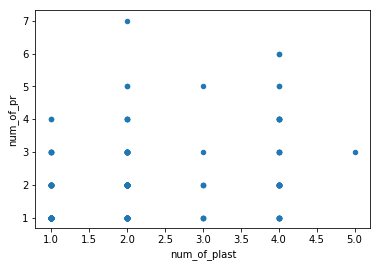

In [34]:
df_all_train_0[['clust', 'num_of_plast', 'num_of_pr']].plot.scatter(x = 'num_of_plast', y = 'num_of_pr')

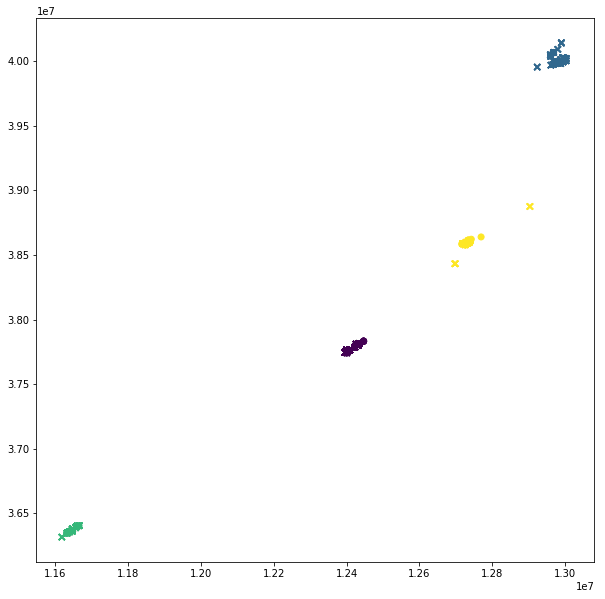

In [26]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.scatter(df_all_train[~df_all_train['ПЛАСТ_X'].isnull()]['ПЛАСТ_X'], 
            df_all_train[~df_all_train['ПЛАСТ_X'].isnull()]['ПЛАСТ_Y'],
            marker = 'x',
            c = df_all_train[~df_all_train['ПЛАСТ_X'].isnull()]['clust'])

plt.scatter(df_all_test[~df_all_test['ПЛАСТ_X'].isnull()]['ПЛАСТ_X'], 
            df_all_test[~df_all_test['ПЛАСТ_X'].isnull()]['ПЛАСТ_Y'], 
            marker = 'o',
            c = df_all_test[~df_all_test['ПЛАСТ_X'].isnull()]['clust'])
#for xx, yy, txt in np.broadcast(df_all_test[~df_all_train['ПЛАСТ_X'].isnull()]['ПЛАСТ_X'] + 20, 
#                                df_all_test[~df_all_train['ПЛАСТ_X'].isnull()]['ПЛАСТ_Y'] + 20,
#                                    df_all_test[~df_all_train['ПЛАСТ_X'].isnull()]['index']):
#                plt.annotate(txt, (xx, yy), clip_on = True)
#plt.legend()

Пример таблицы с дебитами жидкости по каждой скважине

In [155]:
df_all_train.head()

,Скважина,Дата,liq_rate,oil_rate,wct,gas_rate,gf,gas_prod,days_on,oil_prod,frac,month,Давление пластовое,ПЛАСТ_X,ПЛАСТ_Y,clust
0,005642f48d3e86d871bb701bac2ba042,2005-06-01,29.777778,29.722222,0.001866,1642.666667,64.0,29568.0,18.0,462.0,1.0,0,103.15,NaN,NaN,NaN
1,005642f48d3e86d871bb701bac2ba042,2005-07-01,6.290323,6.290323,0.000000,350.967742,64.0,10880.0,31.0,170.0,1.0,1,103.15,NaN,NaN,NaN
2,005642f48d3e86d871bb701bac2ba042,2005-08-01,5.366667,5.366667,0.000000,298.666667,64.0,8960.0,30.0,140.0,1.0,2,103.15,NaN,NaN,NaN
3,005642f48d3e86d871bb701bac2ba042,2005-09-01,5.500000,5.500000,0.000000,305.230769,64.0,7936.0,26.0,124.0,1.0,3,103.15,NaN,NaN,NaN
4,005642f48d3e86d871bb701bac2ba042,2005-10-01,9.733333,9.733333,0.000000,541.866667,64.0,16256.0,30.0,254.0,1.0,4,103.15,NaN,NaN,NaN


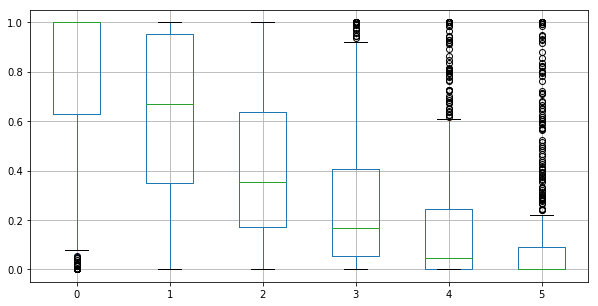

In [35]:
df_liq_train = df_all_train[['Скважина','month', 'liq_rate']].set_index(['Скважина', 'month']).unstack(0).fillna(0)
df_liq_train.columns = df_liq_train.columns.droplevel(0)

liq_scaler = MinMaxScaler()
df_liq_train_norm = pd.DataFrame(liq_scaler.fit(df_liq_train.values).transform(df_liq_train.values), 
                                 index = df_liq_train.index, columns = df_liq_train.columns)
%matplotlib inline
plt.figure(figsize=(10,5))

df_liq_train_norm.T.boxplot()

### Дни работы скважины по месяцам. Видно, что в первом месяце работают в среднем по пол месяца, а дальше уже почти все дни

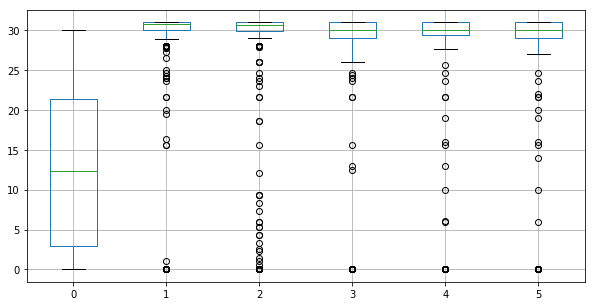

In [36]:
df_days_train = df_all_train[['Скважина','month', 'days_on']].set_index(['Скважина', 'month']).unstack(0).fillna(0)
df_days_train.columns = df_days_train.columns.droplevel(0)
mean_days_on = df_days_train[df_days_train>5].mean(axis = 1).values
%matplotlib inline
plt.figure(figsize=(10,5))
df_days_train.T.boxplot()

### Падение по дебиту нефти

In [39]:
df_oil_train = df_all_train[['Скважина','month', 'oil_rate']].set_index(['Скважина', 'month']).unstack(0).fillna(0)
df_oil_train.columns = df_oil_train.columns.droplevel(0)
oil_scaler = MinMaxScaler()
df_oil_train_norm = pd.DataFrame(oil_scaler.fit(df_oil_train.values).transform(df_oil_train.values), 
                                 index = df_oil_train.index, columns = df_oil_train.columns)
wells_1_0 = df_oil_train.columns[df_oil_train.loc[0,:] < df_oil_train.loc[1,:]]
wells_0_1 = df_oil_train.columns[df_oil_train.loc[0,:] >= df_oil_train.loc[1,:]]


In [1]:
plt.figure(figsize=(10,5))
df_oil_train.T.boxplot()

NameError: name 'plt' is not defined

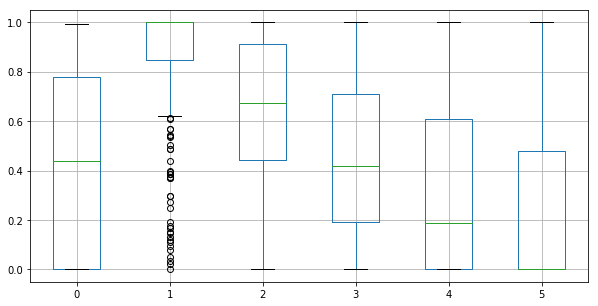

In [41]:
plt.figure(figsize=(10,5))
df_oil_train_norm.loc[:,wells_1_0].T.boxplot()

### Распределение добычи нефти по месяцам

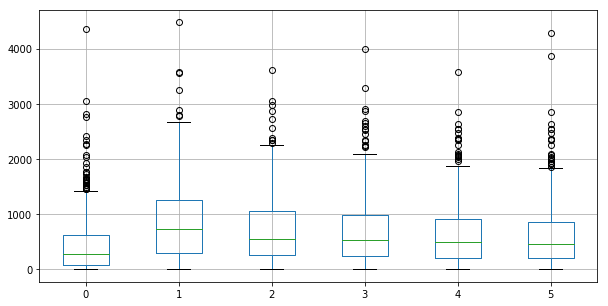

In [42]:
df_oil_prod_train = df_all_train[['Скважина','month', 'oil_prod']].set_index(['Скважина', 'month']).unstack(0)#.fillna(0)
df_oil_prod_train.columns = df_oil_prod_train.columns.droplevel(0)
plt.figure(figsize=(10,5))
df_oil_prod_train.T.boxplot()

In [43]:
oil_prod_mean = df_oil_prod_train.mean(axis = 1).values
oil_prod_median = df_oil_prod_train.median(axis = 1).values

In [44]:
oil_prod_mean

array([456.6398081 , 845.60925373, 724.01638116, 696.33453961,
       641.49119914, 620.66982833])